# Dask  Notes

## Understanding Computer Storage & Big Data
 - Binary computers: base 2:
    - Binary digit (bit)
    - Byte: $2^3$ bits = 8 bits
    - Kilobyte: $2^{10}$ Bytes
    - Megabyte: $2^{20}$ Bytes
    - Gigabyte: $2^{30}$ Bytes
    - Terabyte: $2^{40}$ Bytes
    
- Storage
    - hard disk: permanent, big, slow
        - access time (med) 
            - solid-state disk: 50-150$\mu$s
            - rational disk: 1-10 ms
    - random access memory: temporary, small, fast
        - access time (med): 120 ns
    - c.f internet
        - 40 ms
        
- How Big is Big Data?
    - Data fits in RAM (random access memory)?
    - Data fits on hard disk?

In [1]:
# install pkg if not exist
import pip

def import_or_install(package):
    try:
        __import__(package)
    except ImportError:
        pip.main(['install', package])  

## Querying Python's interpreter memory usage

In [2]:
import_or_install("psutil")
import psutil, os

def memory_footprint():
    '''Return memory in (MB) being used by Python process'''
    memory = psutil.Process(os.getpid()).memory_info().rss
    return(memory / 1024**2)

print("current memory usage is %.2f MB"%(memory_footprint()))

  Running setup.py bdist_wheel for psutil: started
  Running setup.py bdist_wheel for psutil: finished with status 'done'
  Stored in directory: /home/jovyan/.cache/pip/wheels/d2/71/40/9c6993129f8cda369d0f21c46a13a6adab7fb1664fe6512551
Successfully built psutil


You are using pip version 9.0.3, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


current memory usage is 69.20 MB


In [3]:
import pandas as pd
filename = '/home/jovyan/work/WDI_csv/WDIData.csv'
data = pd.read_csv(filename)

In [4]:
display(data.shape)
data.loc[(data['Country Code'] == 'AUS')].head()

pd.melt(data, id_vars=['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code'],
            var_name='Year', value_name='value').head()

(422400, 63)

,Country Name,Country Code,Indicator Name,Indicator Code,Year,value
0,Arab World,ARB,"2005 PPP conversion factor, GDP (LCU per inter...",PA.NUS.PPP.05,1960,NaN
1,Arab World,ARB,"2005 PPP conversion factor, private consumptio...",PA.NUS.PRVT.PP.05,1960,NaN
2,Arab World,ARB,Access to clean fuels and technologies for coo...,EG.CFT.ACCS.ZS,1960,NaN
3,Arab World,ARB,Access to electricity (% of population),EG.ELC.ACCS.ZS,1960,NaN
4,Arab World,ARB,"Access to electricity, rural (% of rural popul...",EG.ELC.ACCS.RU.ZS,1960,NaN


## Read data by chunksize

In [5]:
dfs = []
for chunk in pd.read_csv(filename, chunksize = 1000):
    chunk = pd.melt(chunk, id_vars=['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code'],
            var_name='Year', value_name='value')
    is_urban = chunk['Indicator Name'] =='Urban population (% of total)'
    is_AUS = chunk['Country Code'] == 'AUS'
    filtered = chunk.loc[(is_urban & is_AUS)]
    dfs.append(filtered)

In [6]:
# display(len(dfs))
df = pd.concat(dfs)
display(df.shape)
df.head()

(59, 6)

,Country Name,Country Code,Indicator Name,Indicator Code,Year,value
771,Australia,AUS,Urban population (% of total),SP.URB.TOTL.IN.ZS,1960,81.529
1771,Australia,AUS,Urban population (% of total),SP.URB.TOTL.IN.ZS,1961,81.941
2771,Australia,AUS,Urban population (% of total),SP.URB.TOTL.IN.ZS,1962,82.228
3771,Australia,AUS,Urban population (% of total),SP.URB.TOTL.IN.ZS,1963,82.511
4771,Australia,AUS,Urban population (% of total),SP.URB.TOTL.IN.ZS,1964,82.792


In [7]:
# remove a plausible record
df["Year"].loc[df["Year"].str.contains(r'([a-zA-Z]+)')]
df = df.drop(df.index[df["Year"].str.contains(r'([a-zA-Z]+)')])
df["Year"] = df["Year"].astype('int')
df.dtypes

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  This is separate from the ipykernel package so we can avoid doing imports until


Country Name       object
Country Code       object
Indicator Name     object
Indicator Code     object
Year                int64
value             float64
dtype: object

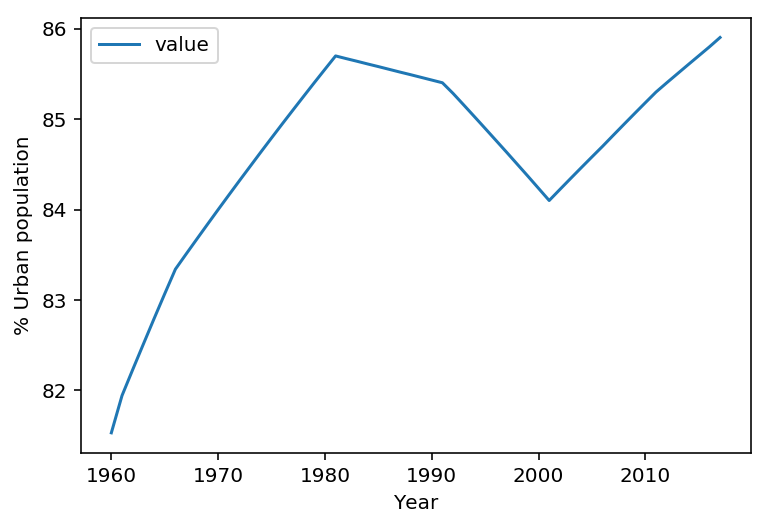

In [8]:
% matplotlib inline
% config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

# Call df.plot.line with x='Year' and y='value'
df.plot.line(x='Year', y='value')
plt.ylabel('% Urban population')

# Call plt.show()
plt.show()

## Generator

In [38]:
filename =  ['/home/jovyan/work/dask_data/flight_data/'+x  for x in  ['jan.csv', 'feb.csv', 'mar.csv', 'apr.csv', 'may.csv']]
# Define the generator: dataframes
dataframes = (pd.read_csv(file) for file in filename) # generator

In [39]:
df_head= [df.head(n=1) for df in dataframes]
df_head

[   ORIGIN_AIRPORT_ID  ORIGIN_AIRPORT_SEQ_ID  ORIGIN_CITY_MARKET_ID  \
 0              10135                1013503                  30135   
 
    DEST_AIRPORT_ID  DEST_AIRPORT_SEQ_ID  DEST_CITY_MARKET_ID  Unnamed: 6  
 0            10397              1039705                30397         NaN  ,
    ORIGIN_AIRPORT_ID  ORIGIN_AIRPORT_SEQ_ID  ORIGIN_CITY_MARKET_ID  \
 0              10135                1013503                  30135   
 
    DEST_AIRPORT_ID  DEST_AIRPORT_SEQ_ID  DEST_CITY_MARKET_ID  Unnamed: 6  
 0            10397              1039705                30397         NaN  ,
    ORIGIN_AIRPORT_ID  ORIGIN_AIRPORT_SEQ_ID  ORIGIN_CITY_MARKET_ID  \
 0              10135                1013503                  30135   
 
    DEST_AIRPORT_ID  DEST_AIRPORT_SEQ_ID  DEST_CITY_MARKET_ID  Unnamed: 6  
 0            10397              1039705                30397         NaN  ,
    ORIGIN_AIRPORT_ID  ORIGIN_AIRPORT_SEQ_ID  ORIGIN_CITY_MARKET_ID  \
 0              10135                1

## [Dask](dask.pydata.org)

- Computing with dask.delayed
- Working with Numpy Arrays
   - Dask arrays:
       - Attributes: shape, ndim, nbytes, dtype, size, etc.
       - Aggregations: max, min, mean, std, var, sum, prod, etc
       - Transformations: reshape, repeat, stack, flatten, transpose, T, etc
       - Mathematical operations: round, real, imag, conj, dot, etc.
       
- Dask Dataframe
     - `import dask.dataframe as dd`
     - `dd.read_csv()` function
          - Accepts single filename or glob pattern (using wildcard *)
          - Does not read file immediately (lazy evaluation)
          - File(s) need not fit in memory
    - Compatibility with Pandas API
          - Unavailable in dask.dataframe:
               - some unsupported file formats (e.g., .xls, .zip, .gz)
               - sorting
          - Available in dask.dataframe:
               - indexing, selection, & reindexing
               - aggregations: .sum(), .mean(), .std(), .min(), .max() etc
               - grouping with .groupby()
               - datetime conversion with dd.to_datetime()
               
    - Best use case for Dask
          - Computations from Pandas API available in Dask
          - Problem size close to limits of RAM, fits on disk
          
    - Limitations of Dask DataFrames
         - Unsupported file formats
         - Cleaning files independently
         - Nested subdirectories tricky with glob
         
    - Merging DataFrames
         - Pandas: `pd.merge()`
         - Pandas: `pd.DataFrame.merge()`
         - Dask: `dask.dataframe.merge()`

In [40]:
import_or_install("dask")

In [46]:
from dask import delayed

# Define count_flights
@delayed
def count_flights(df):
    return len(df)

# Define count
@delayed
def count_delayed(df):
    return (df['ORIGIN_AIRPORT_ID']<10400).sum()

# Define pct
@delayed
def pct(n_oa, n_flights):
    return 100 * sum(n_oa)/sum(n_flights)

In [47]:
n_delayed = []
n_flights = []
for file in filename:
    df = delayed(pd.read_csv(file))
    n_delayed.append(count_delayed(df))
    n_flights.append(count_flights(df))

# Call pct_delayed with n_delayed and n_flights: resul,
result = pct(n_delayed, n_flights)

# Print the output of result.compute()
print(result.compute()) 

8.10017879088


## Dask Bag

In [40]:
import dask.bag as db

nested_container = [[1,2,3], {},[1.2, 1.3], 'gg', {'k':'v'}]

bag =db.from_sequence(nested_container)

In [45]:
display(bag.count().compute())
display(bag.any().compute())
display(bag.all().compute())

5

True

False

In [52]:
import glob

filename = glob.glob('/home/jovyan/work/dask_data/taxi/*.csv')
filename

['/home/jovyan/work/dask_data/taxi/green_tripdata_2017-01.csv',
 '/home/jovyan/work/dask_data/taxi/green_tripdata_2017-02.csv']

## Functional programming
- functions: first-class data
- higher-order functions:
    - function as `input` or output to functions
- Functions replace looop with:
    - map: 
    - filter
    - reduction (or aggreation)

### Map

In [54]:
def squared(x):
    return x ** 2

squares = map(squared, [1,3,5])
squares

In [55]:
list(squares)

[1, 9, 25]

## Filter

In [57]:
def is_even(x):
    return x % 2 == 0
    
even = filter(is_even, [1,2,3,4,5,0])
list(even)

[2, 4, 0]

## Apply dask bag

In [62]:
num = db.from_sequence([1,2,3,4])
display(num.map(squared).compute())
display(num.filter(is_even).compute())
display(num.filter(is_even).min().compute())

[1, 4, 9, 16]

[2, 4]

2

## JSON files

In [70]:
filename = glob.glob('/home/jovyan/work/dask_data/presidents.json')
js = db.read_text(filename  , encoding='latin-1')
js.take(2)


('bplist00Ñ\x01\x02_\x10\x0fWebMainResourceÕ\x03\x04\x05\x06\x07\x08\t\n',
 '\x0b\x0c_\x10\x14WebResourceFrameName_\x10\x0fWebResourceData_\x10\x13WebResourceMIMEType_\x10\x1bWebResourceTextEncodingName^WebResourceURLPO\x11\x1dé<html><head><style id="style-1-cropbar-clipper">/* Copyright 2014 Evernote Corporation. All rights reserved. */\n')

# Example: flight delays

In [72]:
from dask import delayed
@delayed
def read_flights(filename):
    
    df = pd.read_csv(filename, parse_dates=['FL_DATE'])
    # Calculate df['WEATHER_DELAY']
    df['WEATHER_DELAY'] = df['WEATHER_DELAY'].replace(0, np.nan)

    # Return df
    return df

In [83]:
import dask.dataframe as dd
import pandas as pd
import numpy as np
filenames = glob.glob('/home/jovyan/work/dask_data/flightdelays/*.csv')
dataframes = []
# Loop over filenames with index filename
for filename in filenames:
    # Apply read_flights to filename; append to dataframes
    dataframes.append(read_flights(filename))

# Compute flight delays: flight_delays
flight_delays = dd.from_delayed(dataframes)

# Print average of 'WEATHER_DELAY' column of flight_delays
print(flight_delays['WEATHER_DELAY'].mean().compute())

51.2946768061


# Example: weather

In [84]:
# Define @delayed-function read_weather with input filename
@delayed
def read_weather(filename):
    # Read in filename: df
    df = pd.read_csv(filename, parse_dates=['Date'])

    # Clean 'PrecipitationIn'
    df['PrecipitationIn'] = pd.to_numeric(df['PrecipitationIn'], errors='coerce')

    # Create the 'Airport' column
    df['Airport'] = filename.split('.')[0]

    # Return df
    return df

In [89]:
filenames = glob.glob('/home/jovyan/work/dask_data/weatherdata/*.csv')
weather_dfs = []
# Loop over filenames with filename
for filename in filenames:
    # Invoke read_weather on filename; append result to weather_dfs
    weather_dfs.append(read_weather(filename))

# Call dd.from_delayed() with weather_dfs: weather
weather = dd.from_delayed(weather_dfs)

# Print result of weather.nlargest(1, 'Max TemperatureF')
print(weather.nlargest(1, 'Max TemperatureF').compute())


          Date  Max TemperatureF  Mean TemperatureF  Min TemperatureF  \
224 2016-08-12               107                 93                79   

     Max Dew PointF  MeanDew PointF  Min DewpointF  Max Humidity  \
224              75              71             66            79   

     Mean Humidity  Min Humidity                     ...                       \
224             53            27                     ...                        

     Mean VisibilityMiles  Min VisibilityMiles  Max Wind SpeedMPH  \
224                     8                    0                 41   

     Mean Wind SpeedMPH  Max Gust SpeedMPH  PrecipitationIn  CloudCover  \
224                  10               54.0             0.82           5   

                Events  WindDirDegrees  \
224  Rain-Thunderstorm             214   

                                         Airport  
224  /home/jovyan/work/dask_data/weatherdata/DFW  

[1 rows x 24 columns]


In [91]:
# Make cleaned Boolean Series from weather['Events']: is_snowy
is_snowy = weather['Events'].str.contains('Snow').fillna(False)

# Create filtered DataFrame with weather.loc & is_snowy: got_snow
got_snow = weather.loc[is_snowy]

# Groupby 'Airport' column; select 'PrecipitationIn'; aggregate sum(): result
result = got_snow.groupby('Airport')['PrecipitationIn'].sum()

# Compute & print the value of result
print(result.compute())

Airport
/home/jovyan/work/dask_data/weatherdata/DEN    5.59
/home/jovyan/work/dask_data/weatherdata/ATL    1.94
/home/jovyan/work/dask_data/weatherdata/ORD    3.91
Name: PrecipitationIn, dtype: float64
